In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import re
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('/content/drive/MyDrive/laptop-price/Price_euros_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/laptop-price/Price_euros_test.csv')

In [5]:
df.head(10)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
3,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
5,9,Asus,ZenBook UX430UN,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows 10,1.3kg,1495.00
6,11,HP,250 G6,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.90
7,12,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,344.99
8,13,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.8GHz,16GB,256GB SSD,AMD Radeon Pro 555,NaN,1.83kg,2439.97
9,14,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows 10,2.2kg,498.90


In [6]:
df_nan = df.loc[:, df.isnull().any()]

df_nan.isnull().sum() / len(df_nan) * 100 # процент пропущенных значений

,0
ScreenResolution,0.992780
OpSys,4.783394
Weight,1.985560


Видим, что максисальная пустота данных не достигает даже 5%, значит совсем мусорных столбцов нет и мы может заполнить пропуски модой исследуемого столбца.

In [7]:
df['OpSys'] = df['OpSys'].fillna(df['OpSys'].mode()[0])
df['ScreenResolution'] = df['ScreenResolution'].fillna(df['ScreenResolution'].mode()[0])
df['Weight'] = df['Weight'].fillna(df['Weight'].mode()[0])

Теперь все данные преобразуем в числовые

In [8]:
# Разделяем все типы памяти
df['Memory'] = df['Memory'].str.replace(r'(\d+)TB', lambda m: str(int(m.group(1)) * 1024) + 'GB', regex=True)

memory_types = set(re.findall(r'(?<=GB\s)([a-zA-Z]+(?:\s+[a-zA-Z]+)*)', ' '.join(df['Memory'])))
for memory_type in memory_types:
  i = r'(\d+)(?:GB) ' + memory_type
  df[memory_type] = df['Memory'].str.findall(i).apply(
      lambda x: sum([int(i) for i in x]) if x else 0)

df = df.drop('Memory', axis=1)
df.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Flash Storage,Hybrid
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,Intel HD Graphics 6000,macOS,1.34kg,898.94,0,0,128,0
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,AMD Radeon Pro 455,macOS,1.83kg,2537.45,0,512,0,0
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,0,256,0,0


In [9]:
# Отчисим вес от 'kg'
df['Weight'] = df['Weight'].apply(lambda x: re.sub(r'kg', '', x))
df.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Flash Storage,Hybrid
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,128,0
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,AMD Radeon Pro 455,macOS,1.83,2537.45,0,512,0,0
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0,256,0,0


In [10]:
# Отчисим ram от 'GB'
df['Ram'] = df['Ram'].apply(lambda x: re.sub(r'GB', '', x))
df.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Flash Storage,Hybrid
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,128,0
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,2537.45,0,512,0,0
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0,256,0,0


In [11]:
# Заменим 'ScreenResolution' на диагональное разрешение

df['ScreenResolution'] = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)').apply(lambda row: np.sqrt(int(row[0])**2 + int(row[1])**2), axis=1)

df.head(8)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,HDD,SSD,Flash Storage,Hybrid
0,2,Apple,Macbook Air,Ultrabook,13.3,1698.116604,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,128,0
1,4,Apple,MacBook Pro,Ultrabook,15.4,3396.233208,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,2537.45,0,512,0,0
2,5,Apple,MacBook Pro,Ultrabook,13.3,3018.873962,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0,256,0,0
3,6,Acer,Aspire 3,Notebook,15.6,1567.092850,AMD A9-Series 9420 3GHz,4,AMD Radeon R5,Windows 10,2.1,400.00,500,0,0,0
4,7,Apple,MacBook Pro,Ultrabook,15.4,3396.233208,Intel Core i7 2.2GHz,16,Intel Iris Pro Graphics,Mac OS X,2.04,2139.97,0,0,256,0
5,9,Asus,ZenBook UX430UN,Ultrabook,14.0,2202.907170,Intel Core i7 8550U 1.8GHz,16,Nvidia GeForce MX150,Windows 10,1.3,1495.00,0,512,0,0
6,11,HP,250 G6,Notebook,15.6,1567.092850,Intel Core i5 7200U 2.5GHz,4,Intel HD Graphics 620,No OS,1.86,393.90,500,0,0,0
7,12,HP,250 G6,Notebook,15.6,2202.907170,Intel Core i3 6006U 2GHz,4,Intel HD Graphics 520,No OS,1.86,344.99,500,0,0,0


In [12]:
# Удалим столбец 'laptop_ID', так как он не несет никакой информации об устройстве
# Также удалим столбец 'Inches'

df = df.drop('laptop_ID', axis=1)
df = df.drop('Inches', axis=1)

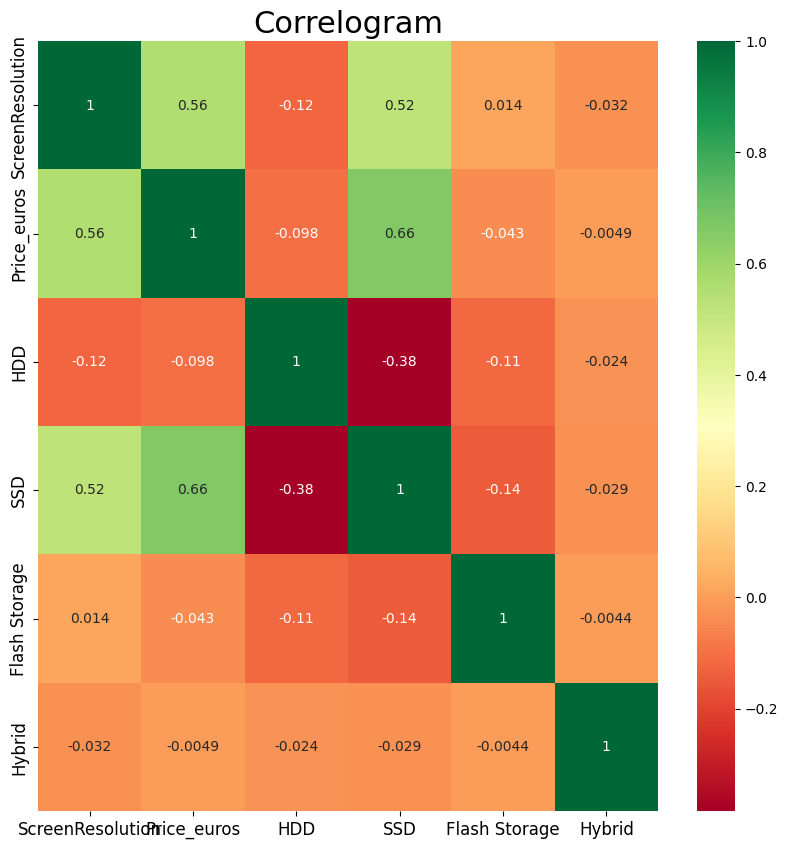

In [13]:
plt.figure(figsize=(10,10))
num = df.select_dtypes(include =['number'])
sns.heatmap(num.corr(), cmap='RdYlGn', annot=True)

plt.title('Correlogram', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Мы можем видеть, что от размера экрана цена практически не зависит, значит можем удалить данный столбец

In [14]:
# делаем аналогичные преобразования для df_test с помощью следующей функции
def normy(df):

  for column in df.columns:
    df[column] = df[column].fillna(df[column].mode()[0])


  df['Memory'] = df['Memory'].str.replace(r'(\d+)TB', lambda m: str(int(m.group(1)) * 1024) + 'GB', regex=True)


  memory_types = set(re.findall(r'(?<=GB\s)([a-zA-Z]+(?:\s+[a-zA-Z]+)*)', ' '.join(df['Memory'])))
  for memory_type in memory_types:
    i = r'(\d+)(?:GB) ' + memory_type
    df[memory_type] = df['Memory'].str.findall(i).apply(
        lambda x: sum([int(i) for i in x]) if x else 0)
  df = df.drop('Memory', axis=1)


  df['Weight'] = df['Weight'].apply(lambda x: re.sub(r'kg', '', x))


  df['Ram'] = df['Ram'].apply(lambda x: re.sub(r'GB', '', x))


  df['ScreenResolution'] = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)').apply(lambda row: np.sqrt(int(row[0])**2 + int(row[1])**2), axis=1)


  df = df.drop('laptop_ID', axis=1)
  df = df.drop('Inches', axis=1)

  return df

In [15]:
df['Company'] = df['Company'].fillna('')

df_test['Company'] = df_test['Company'].fillna('')

In [16]:
# Создаем разряженную матрицу для столбца Company для тренировочных и для тестовых данных
vectorizer=CountVectorizer()

vectorizer.fit(df["Company"])

train_texts = vectorizer.transform(df["Company"])

test_texts = vectorizer.transform(df_test["Company"])

In [17]:
# Преобразуем разряженную матрицу в датафрейм, где названия столбцов - это отдельные слова из данных изначального столбца
company_train = pd.DataFrame(data = train_texts.toarray(), columns=vectorizer.get_feature_names_out())

# Делаем тоже самое для df_test
company_test = pd.DataFrame(data = test_texts.toarray(), columns=vectorizer.get_feature_names_out())

company_train.head()

,acer,apple,asus,chuwi,dell,fujitsu,google,hp,lenovo,lg,mediacom,microsoft,msi,razer,samsung,toshiba,vero,xiaomi
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
Vectorizer=CountVectorizer(max_features=119)

vectorizer.fit(df["Cpu"])

train_texts = vectorizer.transform(df["Cpu"])
test_texts = vectorizer.transform(df_test["Cpu"])

cpu_train = pd.DataFrame(data = train_texts.toarray(), columns=vectorizer.get_feature_names_out())
cpu_test = pd.DataFrame(data = test_texts.toarray(), columns=vectorizer.get_feature_names_out())

cpu_train.head()

,0ghz,1505m,1535m,1600,1700,1ghz,2ghz,3205u,3855u,3ghz,...,quad,ryzen,samsung,series,v5,v6,x5,xeon,z8350,z8550
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
Vectorizer=CountVectorizer(max_features=119)

vectorizer.fit(df["Gpu"])

train_texts = vectorizer.transform(df["Gpu"])
test_texts = vectorizer.transform(df_test["Gpu"])

gpu_train = pd.DataFrame(data = train_texts.toarray(), columns=vectorizer.get_feature_names_out())
gpu_test = pd.DataFrame(data = test_texts.toarray(), columns=vectorizer.get_feature_names_out())

gpu_train.head()

,039c,1050,1050m,1050ti,1060,1070,1070m,1080,150mx,3000m,...,r9,radeon,rx,sli,t860,ti,uhd,w4190m,w5130m,w6150m
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
gpu_train.max().max()

1

In [21]:
df['OpSys'] = df['OpSys'].fillna('')

df_test['OpSys'] = df_test['OpSys'].fillna('')

In [22]:
Vectorizer=CountVectorizer(max_features=119)

vectorizer.fit(df["OpSys"])

train_texts = vectorizer.transform(df["OpSys"])
test_texts = vectorizer.transform(df_test["OpSys"])

opsys_train = pd.DataFrame(data = train_texts.toarray(), columns=vectorizer.get_feature_names_out())
opsys_test = pd.DataFrame(data = test_texts.toarray(), columns=vectorizer.get_feature_names_out())

opsys_train.head()

,10,android,chrome,linux,mac,macos,no,os,windows
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,1,0


In [23]:
df['Product'] = df['Product'].fillna('')
df_test['Product'] = df_test['Product'].fillna('')

Vectorizer=CountVectorizer(max_features=200)

vectorizer.fit(df["Product"])

train_texts = vectorizer.transform(df["Product"])
test_texts = vectorizer.transform(df_test["Product"])

product_train = pd.DataFrame(data = train_texts.toarray(), columns=vectorizer.get_feature_names_out())
product_test = pd.DataFrame(data = test_texts.toarray(), columns=vectorizer.get_feature_names_out())

product_train.head()

,074us,1008gb,100s,1030,1040,10e,10g,10h,10j,10k,...,y900,y910,yoga,z30,z40,z50,z8350,zbook,zenbook,zephyrus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df['TypeName'] = df['TypeName'].fillna('')
df_test['TypeName'] = df_test['TypeName'].fillna('')

Vectorizer=CountVectorizer(max_features=200)

vectorizer.fit(df["TypeName"])

train_texts = vectorizer.transform(df["TypeName"])
test_texts = vectorizer.transform(df_test["TypeName"])

typename_train = pd.DataFrame(data = train_texts.toarray(), columns=vectorizer.get_feature_names_out())
typename_test = pd.DataFrame(data = test_texts.toarray(), columns=vectorizer.get_feature_names_out())

typename_train.head()

,convertible,gaming,in,netbook,notebook,ultrabook,workstation
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0


In [25]:
# Теперь удаляем из изначальной матрицы все рассмотренные столбцы, и присоединяем полученные выше матрицы
df = df.drop(['Company', 'Product', 'Cpu', 'TypeName', 'Gpu', 'OpSys'], axis = 1)
df

,ScreenResolution,Ram,Weight,Price_euros,HDD,SSD,Flash Storage,Hybrid
0,1698.116604,8,1.34,898.94,0,0,128,0
1,3396.233208,16,1.83,2537.45,0,512,0,0
2,3018.873962,8,1.37,1803.60,0,256,0,0
3,1567.092850,4,2.1,400.00,500,0,0,0
4,3396.233208,16,2.04,2139.97,0,0,256,0
...,...,...,...,...,...,...,...,...
1103,1567.092850,4,2.2,720.32,500,0,0,0
1104,2202.907170,4,1.8,638.00,0,128,0,0
1105,1567.092850,2,1.5,229.00,0,0,64,0
1106,1567.092850,6,2.19,764.00,1024,0,0,0


In [26]:
df = pd.merge(df,typename_train, left_index = True, right_index = True)
df = pd.merge(df,product_train, left_index = True, right_index = True)
df = pd.merge(df,opsys_train, left_index = True, right_index = True)
df = pd.merge(df,gpu_train, left_index = True, right_index = True)
df = pd.merge(df,cpu_train, left_index = True, right_index = True)
df = pd.merge(df, company_train, left_index = True, right_index = True)
df

,ScreenResolution,Ram,Weight,Price_euros,HDD,SSD,Flash Storage,Hybrid,convertible,gaming,...,lenovo_y,lg,mediacom,microsoft,msi_y,razer,samsung_y,toshiba,vero,xiaomi
0,1698.116604,8,1.34,898.94,0,0,128,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3396.233208,16,1.83,2537.45,0,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3018.873962,8,1.37,1803.60,0,256,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1567.092850,4,2.1,400.00,500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3396.233208,16,2.04,2139.97,0,0,256,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1567.092850,4,2.2,720.32,500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1104,2202.907170,4,1.8,638.00,0,128,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1105,1567.092850,2,1.5,229.00,0,0,64,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1106,1567.092850,6,2.19,764.00,1024,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_test = df_test.drop(['Company', 'Product', 'Cpu', 'TypeName', 'Gpu','OpSys'], axis = 1)
df_test

,laptop_ID,Inches,ScreenResolution,Ram,Memory,Weight
0,86,15.6,1366x768,4GB,1TB HDD,2.1kg
1,1249,14.0,Full HD 1920x1080,16GB,1TB SSD,1.95kg
2,122,15.6,Full HD 1920x1080,8GB,256GB SSD,1.7kg
3,993,17.3,Full HD 1920x1080,16GB,256GB SSD + 1TB HDD,2.99kg
4,739,15.6,1366x768,12GB,1TB HDD,2.25kg
...,...,...,...,...,...,...
190,876,15.6,Full HD 1920x1080,4GB,500GB HDD,2.07kg
191,282,15.6,IPS Panel Full HD 1920x1080,8GB,1TB HDD,2.2kg
192,528,13.3,IPS Panel Full HD 1920x1080,8GB,256GB SSD,1.32kg
193,1204,15.6,Full HD / Touchscreen 1920x1080,16GB,512GB SSD,2.09kg


In [28]:
df_test = normy(df_test)
df_test = pd.merge(df_test,typename_test, left_index = True, right_index = True)
df_test = pd.merge(df_test,product_test, left_index = True, right_index = True)
df_test = pd.merge(df_test,opsys_test, left_index = True, right_index = True)
df_test = pd.merge(df_test,gpu_test, left_index = True, right_index = True)
df_test = pd.merge(df_test,cpu_test, left_index = True, right_index = True)
df_test = pd.merge(df_test,company_test, left_index = True, right_index = True)
df_test

,ScreenResolution,Ram,Weight,HDD,SSD,Flash Storage,Hybrid,convertible,gaming,in,...,lenovo_y,lg,mediacom,microsoft,msi_y,razer,samsung_y,toshiba,vero,xiaomi
0,1567.09285,4,2.1,1024,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2202.90717,16,1.95,0,1024,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2202.90717,8,1.7,0,256,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2202.90717,16,2.99,1024,256,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1567.09285,12,2.25,1024,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,2202.90717,4,2.07,500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191,2202.90717,8,2.2,1024,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,2202.90717,8,1.32,0,256,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,2202.90717,16,2.09,0,512,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Переходим к обучению модели

In [30]:
X_test = df_test
X_train = df.drop('Price_euros', axis=1)
Y_train =df['Price_euros']



In [31]:
'''RFC = RandomForestRegressor()
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_results = cross_val_score(RFC, X_train, Y_train, cv=kf, scoring='r2')

accuracy = cv_results
average_accuracy = cv_results.mean()

print("accuracy scores for each fold:", accuracy)
print("Average accuracy across all folds:", average_accuracy)'''

'RFC = RandomForestRegressor()\nkf = KFold(n_splits=3, shuffle=True, random_state=42)\ncv_results = cross_val_score(RFC, X_train, Y_train, cv=kf, scoring=\'r2\')\n\naccuracy = cv_results\naverage_accuracy = cv_results.mean()\n\nprint("accuracy scores for each fold:", accuracy)\nprint("Average accuracy across all folds:", average_accuracy)'

In [32]:
'''RFC.fit(X_train, Y_train)

Y_pred = RFC.predict(df_test)'''

'RFC.fit(X_train, Y_train)\n\nY_pred = RFC.predict(df_test)'

In [33]:
'''from sklearn.linear_model import LassoCV
model = LassoCV()
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_train, Y_train, cv=kf, scoring='r2')

accuracy = cv_results
average_accuracy = cv_results.mean()

print("accuracy scores for each fold:", accuracy)
print("Average accuracy across all folds:", average_accuracy)



model.fit(X_train, Y_train)
Y_pred = model.predict(df_test)'''

'from sklearn.linear_model import LassoCV\nmodel = LassoCV()\nkf = KFold(n_splits=3, shuffle=True, random_state=42)\ncv_results = cross_val_score(model, X_train, Y_train, cv=kf, scoring=\'r2\')\n\naccuracy = cv_results\naverage_accuracy = cv_results.mean()\n\nprint("accuracy scores for each fold:", accuracy)\nprint("Average accuracy across all folds:", average_accuracy)\n\n\n\nmodel.fit(X_train, Y_train)\nY_pred = model.predict(df_test)'

In [34]:
from sklearn.linear_model import RidgeCV
model = RidgeCV()

kf = KFold(shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_train, Y_train, cv=kf, scoring='r2')

accuracy = cv_results
average_accuracy = cv_results.mean()

print("accuracy scores for each fold:", accuracy)
print("Average accuracy across all folds:", average_accuracy)



model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

accuracy scores for each fold: [0.87757106 0.86786936 0.89274581 0.84494496 0.86756809]
Average accuracy across all folds: 0.8701398570260668


In [35]:
df_ans = pd.DataFrame(Y_pred)
df_ans.index.name = 'index'
df_ans.columns = ['Price_euros']
df_ans

,Price_euros
index,
0,353.105252
1,3126.105454
2,867.548626
3,1694.889489
4,716.114302
...,...
190,670.194341
191,754.934312
192,1601.186249


In [36]:
df_ans.to_csv("answer.csv", index=True)